## Dependencies

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

from time import time

In [2]:
# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Choice of dataset

The first possible dataset is **permuted MNIST**. The model will be trained on different variations of the same dataset. Each variation corresponds to a different classification task as stated in the paper. The permuted MNIST dataset consists in fist flattening the black and white images of hand written digits and applying a random permutation to the whole dataset of flattened pixel data vectors.

The second possible dataset is **rotated MNIST**. Each variation corresponds to MNIST rotated by $ 10(i-1)$ degree if $i$ is the index of the variation/task.

In [3]:
BATCH_SIZE = 128
VAL_FRAC   = 0.1
DEBUG      = True # accelerate code tests

TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

def take_subset(dataset, frac):
    subset_size = int(frac * len(dataset))
    indices = torch.randperm(len(dataset))[:subset_size]
    return Subset(dataset, indices)

def generate_permuted_mnist(i):
    # load dataset
    raw_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=TRANSFORM, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=TRANSFORM, download=True)
    
    # Permute dataset splits
    permutation = torch.randperm(28 * 28)
    raw_dataset.data = raw_dataset.data.view(-1, 28 * 28)[:, permutation].view(-1, 28, 28)
    test_dataset.data = test_dataset.data.view(-1, 28 * 28)[:, permutation].view(-1, 28, 28)

    # DEBUG CODE
    if DEBUG:
        raw_dataset = take_subset(raw_dataset, 0.1)
        test_dataset = take_subset(test_dataset, 0.1)

    # Split train into train and validation
    val_size = int(VAL_FRAC * len(raw_dataset))
    train_size = len(raw_dataset) - val_size
    torch.manual_seed(42) # make sure epochs have the same validation dataset
    train_dataset, val_dataset = torch.utils.data.random_split(raw_dataset, [train_size, val_size])
    
    # Turn into data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

def generate_rotated_mnist(i):
    raise Exception("TODO")

def generate_tasks(n_tasks, dataset_gen):
    """
    Used to generate N dataloaders corresponding to N different tasks.
    Training dataset is split into training and validation.
    """

    train_loaders = []
    val_loaders = []
    test_loaders = []

    for i_task in range(n_tasks):
        train_loader, val_loader, test_loader = dataset_gen(i_task)

        print(f'Task {i_task + 1} Splits: {len(train_loader.dataset)} train, {len(val_loader.dataset)} val, {len(test_loader.dataset)} test')
            
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)
        test_loaders.append(test_loader)
    
    return train_loaders, val_loaders, test_loaders


## Util Functions

### Validation

Appendix 4.1 suggests figure 3B was realized using early stopping, which requires the use of a validation split. For this reason, we split the training dataset into a validation and training dataset. Early stopping is as follows in the paper: if validation is seen increasing 5 consecutive times (arbitrary threshold), training is stopped and the model performing the best on previous epochs is kept. This requires to periodically save the dataset and load again the best performing model at the end of the training function.

Validation dataset is used to compute the validation loss, however the test set is used to compute the test accuracy (or `Fraction correct` in the paper).

In [4]:
def evaluate_accuracy(
    model: torch.nn.Module,
    test_dataloader: DataLoader,
    device: torch.device,
):
    """
    Evaluate test accuracy of the given model on the test split
    """

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

In [5]:
def validate_epoch(
    model: torch.nn.Module,
    val_dataloader: DataLoader,
    criterion,
    device: torch.device,
):
    """
    This function validates the model on the validation dataset.
    """

    val_loss = 0.0
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_dataloader):
            # move data and target to device
            data, target = data.to(device), target.to(device)

            # do the forward pass
            output = model(data)

            # compute the loss
            loss = criterion(output, target)

            # print statistics
            val_loss += loss.item()

    return val_loss / len(val_dataloader)

### Training Functions

In [6]:
def train_epoch(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion,
    device: torch.device,
):
    """
    Training function. Loads the batch, perform forward pass, compute gradients and perform backward pass.
    Only difference is that you can pass the loss function as an argument.
    This allows to use a simple cross entropy loss function, or a more complex one including L2 or EWC regularization.
    """

    train_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = criterion(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        # print statistics
        train_loss += loss.item()

    return train_loss / len(train_dataloader)

def fit(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    test_dataloaders: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LRScheduler,
    criterion,
    epochs: int,
    device: torch.device,
    i_task: int,
):
    """
    The fit method calls the train_epoch() method for a specified
    number of epochs and returns the train and validation losses.
    """

    global N_TASKS

    # keep track of losses and accuracies
    train_losses = []
    val_losses = []
    test_accuracies = [[] for _ in range(N_TASKS)]
    for epoch in range(epochs):
        
        t = time() # current time

        # train function
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
        )
        train_losses.append(train_loss)

        # validate epoch
        val_loss = validate_epoch(
            model=model,
            val_dataloader=val_dataloader,
            criterion=criterion,
            device=device,
        )
        val_losses.append(val_loss)

        # compute test accuracies on all tasks so far
        for task_idx in range(N_TASKS):
            if task_idx <= i_task:
                test_accuracy = evaluate_accuracy(
                    model=model,
                    test_dataloader=test_dataloaders[task_idx],
                    device=device,
                )
            else:
                test_accuracy = 0
            test_accuracies[task_idx].append(test_accuracy)
        
        # step scheduler if needed
        if scheduler != None:
            scheduler.step()

        dt = time() - t # time difference
        print(f"Epoch [{epoch + 1}/{epochs}]: train={round(train_loss, 4)} val={round(val_loss, 4)} test={round(test_accuracy, 4)} ({round(dt, 1)}s)")

    return train_losses, val_losses, test_accuracies


## Loss Functions

In [7]:
def ewc_loss():
    # TODO
    pass

## Model architecture

In [8]:
class SmallNet(torch.nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()

        self._input_size = 28 * 28
        self._n_ff       = 100
        self._n_output   = 10
        self._do_input   = 0
        self._do_ff      = 0
        
        self.do0 = torch.nn.Dropout(self._do_input)

        self.ff1 = torch.nn.Linear(self._input_size, self._n_ff)
        self.do1 = torch.nn.Dropout(self._do_ff)

        self.ff2 = torch.nn.Linear(self._n_ff, self._n_ff)
        self.do2 = torch.nn.Dropout(self._do_ff)

        #self.ff3 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do3 = torch.nn.Dropout(self._do_ff)

        #self.ff4 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do4 = torch.nn.Dropout(self._do_ff)

        #self.ff5 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do5 = torch.nn.Dropout(self._do_ff)

        #self.ff6 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do6 = torch.nn.Dropout(self._do_ff)

        self.ff7 = torch.nn.Linear(self._n_ff, self._n_output)

    def forward(self, x):

        # input dropout of 20% as stated in paper
        x = self.do0(x)

        # dense FF hidden layers, each with 50% dropout and ReLU activation
        # dropout is generally placed after the activation
        x = self.do1(F.relu(self.ff1(x)))
        x = self.do2(F.relu(self.ff2(x)))
        #x = self.do3(F.relu(self.ff3(x)))
        #x = self.do4(F.relu(self.ff4(x)))
        #x = self.do5(F.relu(self.ff5(x)))
        #x = self.do6(F.relu(self.ff6(x)))

        # classification layer
        x = self.ff7(x)

        return x

print("Model Parameters: ", sum(p.numel() for p in SmallNet().parameters()))

Model Parameters:  89610


### Training Script

The training script generates $N$ different tasks and calls the `fit(..)` function as many times on different tasks. It then saves the curves and model obtained. It has to be ran multiple times with different loss functions to generate subfigure 2A

No scheduler seems to have been used in the paper, so we are not using any here.

Task 1 Splits: 5400 train, 600 val, 1000 test
Task 2 Splits: 5400 train, 600 val, 1000 test
Task 3 Splits: 5400 train, 600 val, 1000 test
Model Reset. Starting at task 1.
Training on task 1...
Epoch [1/3]: train=2.3019 val=2.3014 test=0 (1.1s)
Epoch [2/3]: train=2.2926 val=2.2908 test=0 (1.2s)
Epoch [3/3]: train=2.2822 val=2.2796 test=0 (0.9s)
Training on task 2...
Epoch [1/3]: train=2.3015 val=2.2965 test=0 (1.0s)
Epoch [2/3]: train=2.29 val=2.2857 test=0 (1.0s)
Epoch [3/3]: train=2.2782 val=2.274 test=0 (1.0s)
Training on task 3...
Epoch [1/3]: train=2.2656 val=2.2604 test=0.381 (1.1s)
Epoch [2/3]: train=2.2501 val=2.2438 test=0.452 (1.0s)
Epoch [3/3]: train=2.2312 val=2.2226 test=0.482 (1.1s)
Plotting curves...


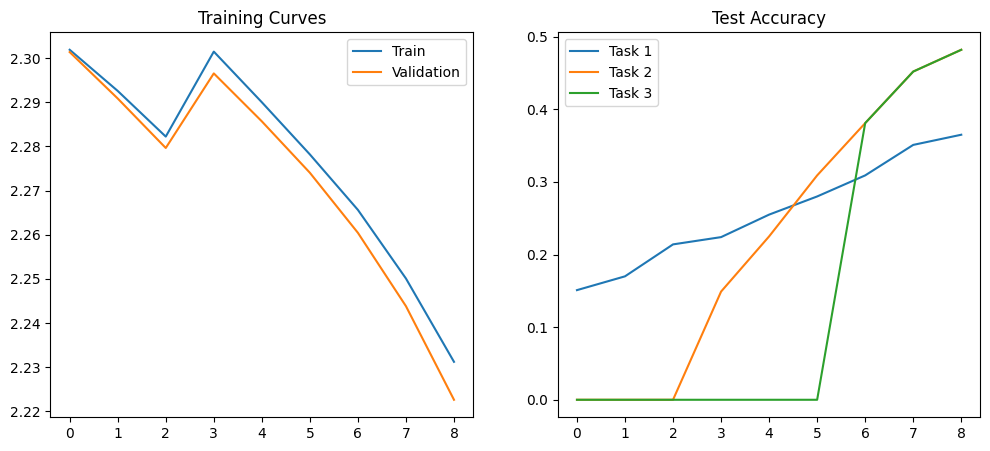

Model Reset. Starting at task 2.
Training on task 2...
Epoch [1/3]: train=2.3096 val=2.3036 test=0 (1.0s)
Epoch [2/3]: train=2.2973 val=2.2915 test=0 (1.2s)
Epoch [3/3]: train=2.2844 val=2.2789 test=0 (1.2s)
Training on task 3...
Epoch [1/3]: train=2.2702 val=2.2639 test=0.395 (1.1s)
Epoch [2/3]: train=2.2534 val=2.2454 test=0.506 (1.3s)
Epoch [3/3]: train=2.2321 val=2.2223 test=0.56 (1.1s)
Plotting curves...


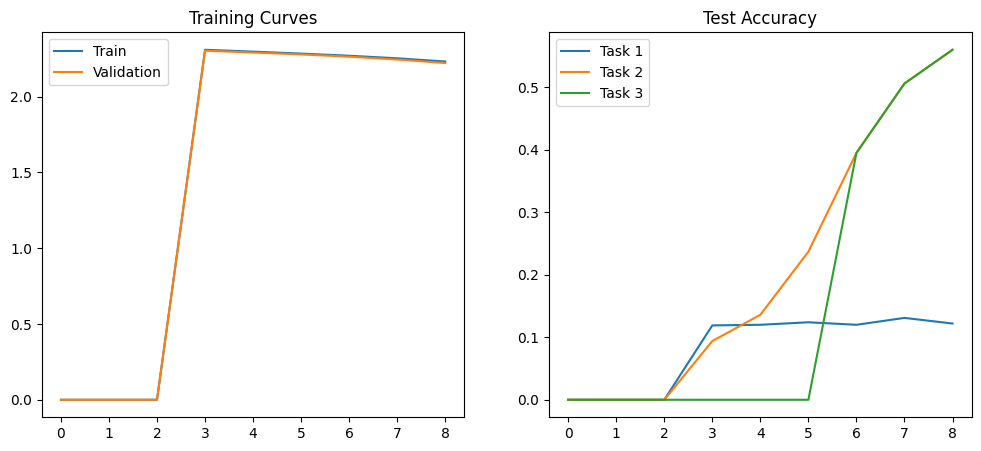

Model Reset. Starting at task 3.
Training on task 3...
Epoch [1/3]: train=2.3036 val=2.3003 test=0.131 (1.2s)
Epoch [2/3]: train=2.2937 val=2.2891 test=0.161 (1.3s)
Epoch [3/3]: train=2.2806 val=2.2763 test=0.197 (1.2s)
Plotting curves...


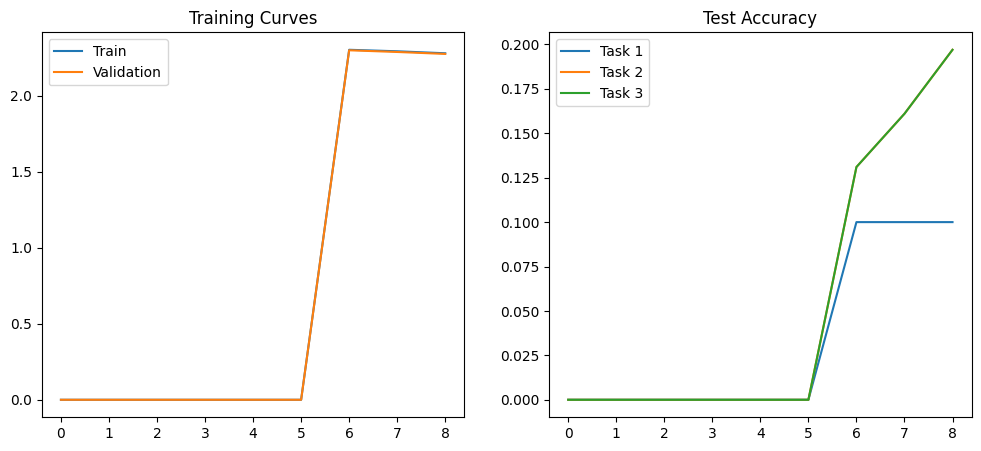

Done!


In [10]:
#################################################################################
# N_EPOCHS    = Number of epochs per task.
# N_TASKS     = Number of tasks to train the model on.
# DATASET_GEN = Type of tasks. We can choose between permuted MNIST and rotated MNIST
# REGUL_TYPE  = Type of regularization. Very important for the paper, as it changes the training process.
#               - `SGD` | Classic SGD with no regularization term
#               - `L2`  | SGD with L2 regularization term
#               - `EWC` | SGD with elastic weight consolidation regularization
#################################################################################
N_EPOCHS    = 3
REGUL_TYPE  = 'SGD'
N_TASKS     = 3
DATASET_GEN = generate_permuted_mnist

train_dataloaders, val_dataloaders, test_dataloaders = generate_tasks(N_TASKS, DATASET_GEN)

for i_starting_task in range(N_TASKS):

    print(f'Model Reset. Starting at task {i_starting_task + 1}.')

    # Initialize model
    model = SmallNet()
    model.to(device)

    # Loss, optimizer and scheduler
    if REGUL_TYPE == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
        criterion = F.cross_entropy
    elif REGUL_TYPE == 'L2':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
        criterion = F.cross_entropy
    elif REGUL_TYPE == 'EWC':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
        raise Exception('Not implemented')
    else:
        raise Exception('Invalid regularization')

    full_train_losses    = []
    full_val_losses      = []
    full_test_accuracies = [[] for _ in range(N_TASKS)]
    
    # padding 0's
    for i_task in range(i_starting_task):
        full_train_losses += [0] * N_EPOCHS
        full_val_losses += [0] * N_EPOCHS
        for task_idx in range(N_TASKS):
            full_test_accuracies[task_idx] += [0] * N_EPOCHS

    for i_task in range(i_starting_task, N_TASKS):

        # Get tasks
        train_dataloader = train_dataloaders[i_task]
        val_dataloader = val_dataloaders[i_task]
        
        print(f'Training on task {i_task + 1}...')

        # Fit on task
        train_losses, val_losses, test_accuracies = fit(
            model=model,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloaders=test_dataloaders,
            optimizer=optimizer,
            scheduler=None,
            criterion=criterion,
            epochs=N_EPOCHS,
            device=device,
            i_task=i_task,
        )

        full_train_losses += train_losses
        full_val_losses += val_losses
        for task_idx in range(N_TASKS):
            full_test_accuracies[task_idx] += test_accuracies[task_idx]

    # Save model and metrics
    #torch.save(model.state_dict(), f'{REGUL_TYPE}.pt') # not used
    np.save(f'{REGUL_TYPE}_train_loss.npy', full_train_losses) # not used
    np.save(f'{REGUL_TYPE}_val_loss.npy', full_val_losses) # not used
    np.save(f'{REGUL_TYPE}_test_accuracy_{i_starting_task + 1}.npy', np.array(full_test_accuracies))

    # Plot loss as fct of epoch
    print('Plotting curves...')
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training and validation losses
    axs[0].plot(full_train_losses, label='Train')
    axs[0].plot(full_val_losses, label='Validation')
    axs[0].legend()
    axs[0].set_title('Training Curves')

    # Plot test accuracy
    for task_idx in range(N_TASKS):
        axs[1].plot(full_test_accuracies[task_idx], label=f'Task {task_idx + 1}')
    axs[1].legend()
    axs[1].set_title('Test Accuracy')

    plt.show()

print('Done!');

## Generate Figure 2A

Follow these steps to generate figure 2A. You can then redo all these steps after changing the dataset from permuted to rotated MNIST using the option `DATASET_GEN`.
The regularization technique used can be chosen by changing the option `REGUL_TYPE`. Each reg technique will save their respective train accuracy curves to different files.

- Run above script with simple cross entropy function (no regularization)
- Run above script with L2 regularization loss function
- Run script above with EWC regularization
- Run the following script which compiles all curves above into one.

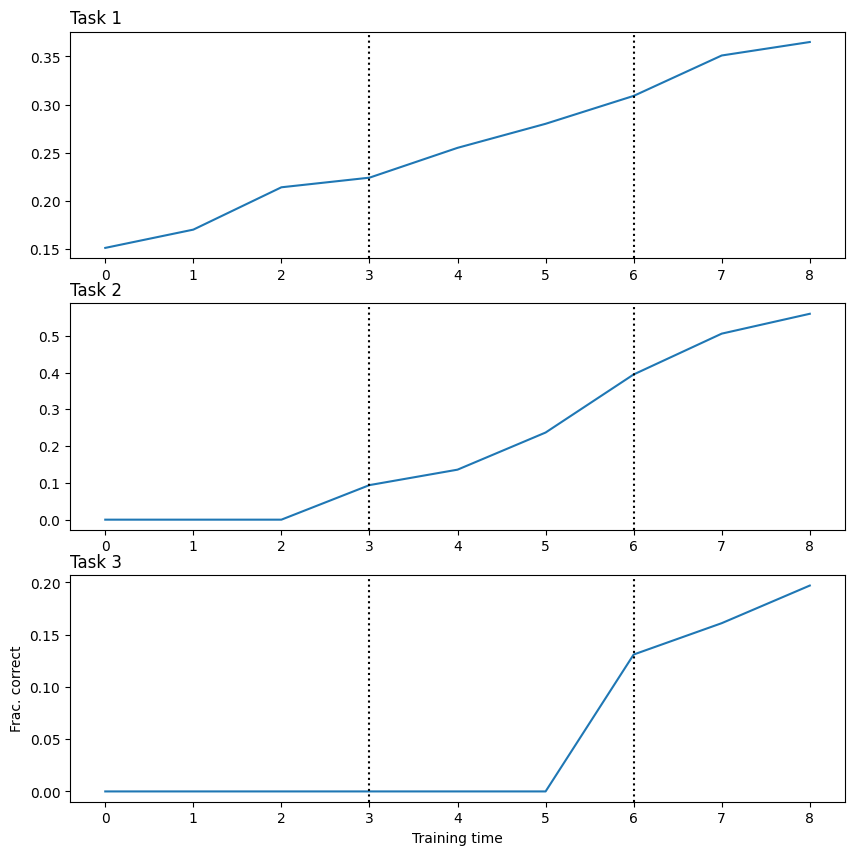

In [23]:
FILE_NAMES = [
    'SGD',
    #'L2',
    #'EWC',
]

fig, axs = plt.subplots(N_TASKS, 1, figsize=(10, 10))

for task_idx in range(N_TASKS):

    axs[task_idx].set_title(f'Task {task_idx + 1}', loc='left')

    for file_name in FILE_NAMES:
        test_accuracy = np.load(f'{file_name}_test_accuracy_{task_idx + 1}.npy')
        axs[task_idx].plot(test_accuracy[task_idx], label=file_name)

# plot dotted lines
for task_idx in range(N_TASKS):
    for i in range(1, N_TASKS):
        axs[task_idx].axvline(x=i * N_EPOCHS, color='black', linestyle=':')

plt.ylabel('Frac. correct')
plt.xlabel('Training time')

plt.show()